In [3]:
from IPython.display import Markdown
import os
from dotenv import load_dotenv
from pydantic_ai import Agent, RunContext
from dataclasses import dataclass
import httpx
from rich import print

In [4]:
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")  # I don't have credit, it's only to show how fallback model wotks.

# Core Concepts

This notebook explores core concepts of Pydantic AI: Agents, Dependencies, and Tools.

## Agent

An Agent is the core abstraction in Pydantic AI. It coordinates model calls, manages context, and orchestrates tool execution.

### Overview

In [5]:
from pydantic_ai import Agent, ModelSettings
from pydantic_ai.models.groq import GroqModel
from pydantic_ai.models.fallback import FallbackModel
from pydantic_ai.models.openai import OpenAIChatModel

# Configure each model with provider-specific settings
openai_model = OpenAIChatModel(
    'gpt-5',
    settings=ModelSettings(temperature=0.2, max_tokens=100)
)
groq_model = GroqModel(
    'llama-3.3-70b-versatile',
    settings=ModelSettings(temperature=1.2, max_tokens=100)
)

# Fallback model: tries OpenAI first, then Groq if it fails
fallback_model = FallbackModel(openai_model, groq_model)
agent = Agent(fallback_model)

### Running the Agent

In [6]:
# Execute agent with a prompt

result = await agent.run('Escreva uma história sobre exploração espacial. Português PT-BR.')

### Inspecting Results

In [7]:
# Display the agent's final output

Markdown(result.output)

**A Jornada ao Fim do Universo**

No ano de 2154, a humanidade havia alcançado um marco inimaginável: a capacidade de explorar o cosmos de forma sistemática e segura. A Agência Espacial Internacional (AEI) havia desenvolvido uma nave espacial revolucionária, batizada de "Horizonte", capaz de viajar para os confins do universo em busca de respostas para

In [8]:
# Inspect all messages: requests, responses, and model reasoning

result.all_messages()

[ModelRequest(parts=[UserPromptPart(content='Escreva uma história sobre exploração espacial. Português PT-BR.', timestamp=datetime.datetime(2025, 11, 4, 3, 50, 55, 250314, tzinfo=datetime.timezone.utc))]),
 ModelResponse(parts=[TextPart(content='**A Jornada ao Fim do Universo**\n\nNo ano de 2154, a humanidade havia alcançado um marco inimaginável: a capacidade de explorar o cosmos de forma sistemática e segura. A Agência Espacial Internacional (AEI) havia desenvolvido uma nave espacial revolucionária, batizada de "Horizonte", capaz de viajar para os confins do universo em busca de respostas para')], usage=RequestUsage(input_tokens=54, output_tokens=100), model_name='llama-3.3-70b-versatile', timestamp=datetime.datetime(2025, 11, 4, 3, 51, tzinfo=TzInfo(0)), provider_name='groq', provider_details={'finish_reason': 'length'}, provider_response_id='chatcmpl-6911050b-ead5-4c4d-b7f1-b9af0cc5a440', finish_reason='length')]

In [9]:
# Access the model's reasoning process

Markdown(result.all_messages()[-1].thinking)

<IPython.core.display.Markdown object>

In [10]:
# Extract which model was used from the fallback chain

provider_name = result.all_messages()[-1].provider_name
model_name = result.all_messages()[-1].model_name

print(f"Provider: {provider_name}")
print(f"Model: {model_name}")

Provider: groq

Model: llama-3.3-70b-versatile

In [11]:
# Extract token usage metrics

request_usage = result.all_messages()[-1].usage

print(f"Input tokens: {request_usage.input_tokens}")
print(f"Output tokens: {request_usage.output_tokens}")

Input tokens: 54

Output tokens: 100

### Key Concepts

- **FallbackModel**: Chains multiple models—if the first fails, it automatically tries the next
- **ModelSettings**: Configure temperature, max_tokens, and other inference parameters per model
- **RunContext**: Provides access to dependencies, messages, and request metadata during execution

## Dependencies

Dependencies enable secure injection of shared resources (HTTP clients, databases, API keys) into agent tools without exposing them to the model.

### Overview

In [12]:
from dataclasses import dataclass
from pydantic_ai import RunContext

# Define a dependency container
@dataclass
class MyDeps:
    """Shared resources injected into agent tools"""
    api_key: str
    http_client: httpx.AsyncClient

### Configure Agent with Dependencies

In [13]:
# Create agent with dependency type hint

agent_with_deps = Agent(
    model='groq:openai/gpt-oss-20b',
    deps_type=MyDeps,
    system_prompt='You are a helpful assistant that can fetch user information.'
)

### Define Tool Using Dependencies

In [14]:
@agent_with_deps.tool
async def get_user_info(ctx: RunContext[MyDeps], user_id: int) -> str:
    """Fetch user information using injected HTTP client and API key"""
    # Access dependencies through context—no need to pass them explicitly
    client = ctx.deps.http_client
    api_key = ctx.deps.api_key
    
    # In production, this would make a real API call
    user_data = {
        'id': user_id,
        'name': f'User {user_id}',
        'email': f'user{user_id}@example.com',
        'authenticated': True
    }
    
    return str(user_data)

### Running Agent with Dependencies

In [15]:
# Instantiate dependencies and pass to agent

async with httpx.AsyncClient() as client:
    deps = MyDeps(
        api_key='sk-example-key',
        http_client=client
    )
    
    result = await agent_with_deps.run(
        'Tell me about user 42.',
        deps=deps
    )

### Inspecting Results

In [16]:
# Display agent output

Markdown(result.output)

Here’s what I found for user 42:

- **ID:** 42  
- **Name:** User 42  
- **Email:** user42@example.com  
- **Authentication status:** ✅ Verified (the user is authenticated)

Let me know if you’d like any other details or next steps!

In [17]:
# View the entire message flow including tool calls

result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='You are a helpful assistant that can fetch user information.', timestamp=datetime.datetime(2025, 11, 4, 3, 51, 0, 362521, tzinfo=datetime.timezone.utc)), UserPromptPart(content='Tell me about user 42.', timestamp=datetime.datetime(2025, 11, 4, 3, 51, 0, 362532, tzinfo=datetime.timezone.utc))]),
 ModelResponse(parts=[ThinkingPart(content='We need to call function get_user_info with user_id 42.'), ToolCallPart(tool_name='get_user_info', args='{"user_id":42}', tool_call_id='fc_e9754e25-c5e7-48e0-a03b-38fed4df5bce')], usage=RequestUsage(input_tokens=147, output_tokens=40), model_name='openai/gpt-oss-20b', timestamp=datetime.datetime(2025, 11, 4, 3, 51, tzinfo=TzInfo(0)), provider_name='groq', provider_details={'finish_reason': 'tool_calls'}, provider_response_id='chatcmpl-163c5953-25af-480d-9d58-1ecc21104dfd', finish_reason='tool_call'),
 ModelRequest(parts=[ToolReturnPart(tool_name='get_user_info', content="{'id': 42, 'name': 'User 42', 'emai

In [18]:
# Extract token usage

request_usage = result.all_messages()[-1].usage

print(f"Input tokens: {request_usage.input_tokens}")
print(f"Output tokens: {request_usage.output_tokens}")

Input tokens: 202

Output tokens: 91

### Key Concepts

- **Dependency Injection**: Resources are passed to the agent, not hardcoded in tools
- **Backend Safety**: Sensitive data (API keys, DB connections) never reach the LLM—only tool logic sees them
- **Resource Reuse**: A single HTTP client or database connection is shared across all tool calls
- **Type Safety**: `deps_type` provides IDE autocompletion and type hints for dependency access

## Function Tools

Tools enable agents to perform actions and access external systems. Pydantic AI supports two types: `@agent.tool` (with RunContext) and `@agent.tool_plain` (without context).

### Overview

This example implements 'Jogo do Bicho' (The Animal Game), a traditional Brazilian lottery game where:
- The agent draws a random animal (1-25)
- Accesses the player's name from dependencies
- Determines if the guess matches the drawn animal

### Tool Execution Flow

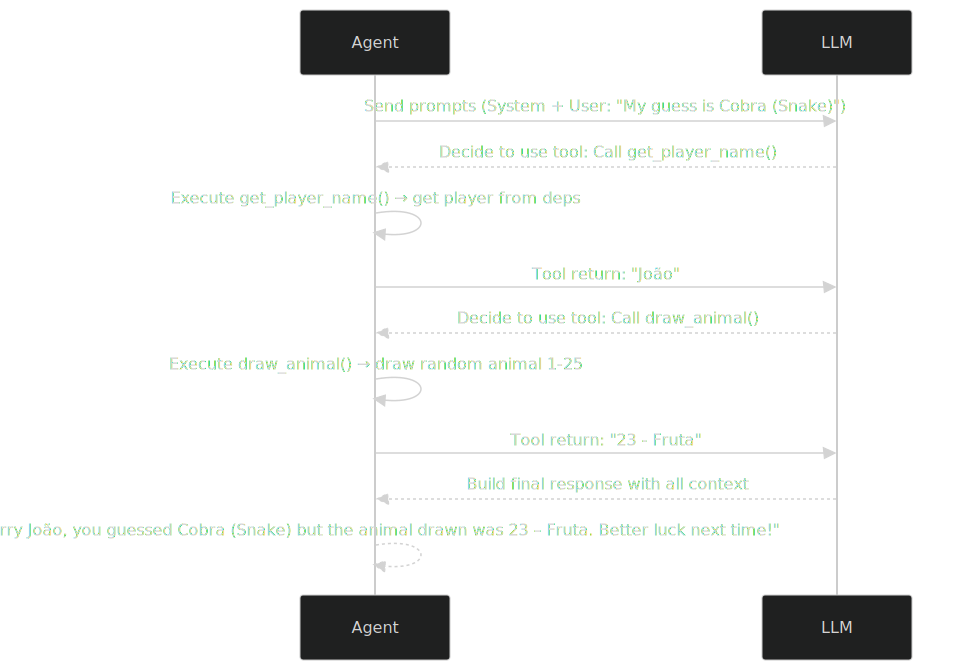

In [26]:
from IPython.display import SVG

# Carrega e exibe o arquivo SVG
SVG(filename='./media/function_tool_diagram.svg')

### Setup

In [19]:
import random

# Agent for 'Jogo do Bicho' game

animal_game = Agent(
    model='groq:openai/gpt-oss-20b',
    deps_type=str,  # Dependencies is just the player's name
    system_prompt=(
        'You are hosting Jogo do Bicho (The Animal Game). Draw a random animal from 1-25, '
        'check if the player\'s guess matches. If correct, celebrate their win. '
        'If wrong, tell them which animal was drawn. Always use the player\'s name in your response.'
    )
)

### Tool without Context

`@agent.tool_plain` is a simple function that doesn't need RunContext or dependencies.

In [20]:
@animal_game.tool_plain
def draw_animal() -> str:
    """Draw a random animal from the Jogo do Bicho game (1-25)."""
    animals = [
        'Avestruz', 'Águia', 'Burro', 'Borboleta', 'Cachorro',
        'Cabra', 'Carneiro', 'Camelo', 'Cobra', 'Coelho',
        'Corvos', 'Cabalo', 'Elefante', 'Estribo', 'Escorpião',
        'Espelho', 'Espingarda', 'Estátua', 'Estrela', 'Estrondo',
        'Foca', 'Formiga', 'Fruta', 'Faisão', 'Fazenda'
    ]
    drawn_number = random.randint(1, 25)
    drawn_animal = animals[drawn_number - 1]
    return f"{drawn_number} - {drawn_animal}"

### Tool with Context

`@agent.tool` has access to RunContext, allowing it to use dependencies.

In [21]:
@animal_game.tool
def get_player_name(ctx: RunContext[str]) -> str:
    """Get the player's name from dependencies."""
    # ctx.deps contains the player name (a simple string)
    return ctx.deps

### Running the Game

In [22]:
# Play the game with player's name as dependency

result = await animal_game.run(
    'My guess is Cobra (Snake)',
    deps='João'  # Player's name
)

### Inspecting Results

In [23]:
# Display game result

Markdown(result.output)

Sorry João, you guessed Cobra (Snake) but the animal drawn was **23 – Fruta**. Better luck next time!

In [24]:
# View all tool calls and responses

result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content="You are hosting Jogo do Bicho (The Animal Game). Draw a random animal from 1-25, check if the player's guess matches. If correct, celebrate their win. If wrong, tell them which animal was drawn. Always use the player's name in your response.", timestamp=datetime.datetime(2025, 11, 4, 3, 51, 2, 78080, tzinfo=datetime.timezone.utc)), UserPromptPart(content='My guess is Cobra (Snake)', timestamp=datetime.datetime(2025, 11, 4, 3, 51, 2, 78097, tzinfo=datetime.timezone.utc))]),
 ModelResponse(parts=[ThinkingPart(content="We need to call get_player_name to get player name. Then draw_animal to get random. Then respond in Portuguese probably. Use player's name. Let's do."), ToolCallPart(tool_name='get_player_name', args='{}', tool_call_id='fc_dbeceb10-9f58-4051-84d6-f64ba3685c06')], usage=RequestUsage(input_tokens=212, output_tokens=54), model_name='openai/gpt-oss-20b', timestamp=datetime.datetime(2025, 11, 4, 3, 51, 2, tzinfo=TzInfo(0)), provider

In [25]:
# Extract token usage

request_usage = result.all_messages()[-1].usage

print(f"Input tokens: {request_usage.input_tokens}")
print(f"Output tokens: {request_usage.output_tokens}")

Input tokens: 263

Output tokens: 124

### Key Concepts

- **`@agent.tool_plain`**: Simple function without context—ideal for stateless operations
- **`@agent.tool`**: Receives `RunContext[DepsType]`—access dependencies, model state, and request info
- **Tool Discovery**: Pydantic AI automatically discovers all decorated tools and exposes them to the model
- **Tool Results**: Tools can return strings, Pydantic models, or JSON-serializable objects
- **Async Support**: Both decorators support async functions for I/O-heavy operations